In [91]:
# Imports
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma
from scipy.constants import physical_constants
from sklearn import preprocessing
import csv
import matplotlib.pyplot as plt

In [92]:
### Define Variables

In [93]:
keV = 1.
electron_mass = 510.9989461 * keV
α = physical_constants['fine-structure constant'][0]

In [94]:
### Define Classes and Functions (from J. Formaggio)

In [95]:
class Isotope:
    def __init__(self, Name, AtomicNumber, AtomicMass, JSpin, Parity):
        self.Name = Name
        self.AtomicNumber = AtomicNumber
        self.AtomicMass = AtomicMass
        self.JSpin = JSpin
        self.Parity = Parity

class DecayProcess:
    def __init__(self, parentAtom, progenyAtom, decayType, deltaJ, deltaP, QValue):
        self.parentAtom = parentAtom
        self.progenyAtom = progenyAtom
        self.decayType = decayType
        self.deltaJ = deltaJ
        self.deltaP = deltaP
        self.QValue = QValue

def SetDecayProcess(Parent, Progeny, QValue):
    dJ = int(abs(Parent.JSpin - Progeny.JSpin))
    dP = int(np.sign(Parent.Parity * Progeny.Parity))   
    return DecayProcess(Parent, Progeny, "β-", dJ, dP, QValue)

def ν(x):
    # Normalize energy by electron mass
    return x / electron_mass + 1

def df2(n):
    # Double factorial implementation
    return np.prod(np.arange(n, 1, step=-2))
            # Okay I have never used a double factorial so???

def R(Z, A=0):
    # Nuclear radius calculation
    # If A is not specified, reconstruct from Z
    # Inputs:  Z (nuclear charge), A (atomic numer)
    # Output:  Nuclear radius
    if A < 1:
        A = 1.82 + 1.90 * Z + 0.01271 * Z**2 - 0.00006 * Z**3
    radius = (0.002908 * A**(1/3) - 0.002437 * A**(-1/3))
    return radius

def p(W, 𝜈=1):
    # Particle normalized momentum (defaults to electron if 𝜈 is unspecified)
    # Inputs: W (normalized energy)
    # Outputs: p (normalized momentum)
    return np.sqrt(W**2 - 𝜈**2) if W >= 𝜈 else 0
            # This line looks like it could vary from mine

def μ(k, Z, W, A=0):
    # Coulomb amplitudes for the beta decay process
    # For k = 1, this is the Fermi function
    # Inputs: 
    #         k (iteration term in sum)
    #         W (normalized electron energy)
    #         Z (progeny charge)
    #         A (atomic mass)
    # Outputs: μ (Coulomb amplitude term for k)
    l = np.sign(k)
    γ = np.sqrt(k**2 - α**2 * Z**2)
    y = α * Z * W / p(W)
    
    𝛋 = γ + 1j * y   
    β = 2 * γ + 1
    omega = 2 * p(W) * R(Z, A)
    
    # ϕ = -(k - 1j * y) * (hyp1f1(𝛋 + 1, β, 1j * omega) - l * (γ - 1j * y * hyp1f1(𝛋, β, 1j * omega)))
    ϕ = np.sqrt(2 * (γ + 1))
    Ω = np.sqrt(np.abs(1 - l * W)) * (omega)**γ * np.exp(np.pi * y / 2) * np.abs(gamma(𝛋)) / gamma(β)
    result = Ω * ϕ / (2 * R(Z, A) * np.sqrt(W))
    return result

def wave_func(k, Z, W, A=0, lambda_appproximation=True):
    # Sum of Coulomb ampliutudes to form electron wave function
    # Inputs: 
    #         k (iteration term in sum)
    #         W (normalized electron energy)
    #         Z (progeny charge)
    #         l (angular momentum term)
    #         A (atomic mass)
    # Outputs: wave_func (electron wave function)
    #          Defaults to 1 in the lambda=1 appproximation
    k_eff = 1 if lambda_appproximation else k
    term1 = abs(μ(k_eff, Z, W, A))**2 + abs(μ(-k_eff, Z, W, A))**2
    term2 = abs(μ(1, Z, W, A))**2 + abs(μ(-1, Z, W, A))**2
    result = term1 / term2
    return result

def Fermi_func(Z, W, A=0):
    # Fermi function based on Coulomb amplitudes
    return (abs(μ(1, Z, W, A))**2 + abs(μ(-1, Z, W, A))**2) / (2 * p(W)**2)

def shape_factor(n, Z, W, p_e, p_ν, A=0):
    # Function that computes the partial matrix elements and the Fermi function for the beta decay process
    sum = 0.0
    for k in range(1, n+2):
        sum += wave_func(k, Z, W, A) * p_e**(2 * (k - 1)) * p_ν**(2 * (n - k + 1)) / df2(2 * k - 1) / df2(2 * (n - k + 1) + 1)
    return df2(2 * n + 1) * sum

def β_spectrum(W_e, W_ν, p_e, p_ν, n, Z, A=0):
    # Calculate neutrino or electron beta decay spectrum
    C_W = shape_factor(n, Z, W_e, p_e, p_ν, A)
    F_Z = Fermi_func(Z, W_e)
    phase_space = (p_e * W_e) * (W_ν * p_ν)
    return F_Z * C_W * phase_space 

def beta_spectrum(process, K_e):
    # Beta electron spectrum
    Q = process.QValue
    Z = process.progenyAtom.AtomicNumber
    A = process.parentAtom.AtomicMass
    n = max(process.deltaJ - 1, 0)
    
    W_e = ν(K_e)          # Total electron energy
    W_ν = ν(Q) - W_e      # Total neutrino energy
    p_e = p(W_e, 1)       # Electron momentum
    p_ν = p(W_ν, 0)       # Neutrino momentum
    
    return β_spectrum(W_e, W_ν, p_e, p_ν, n, Z, A)

def neutrino_spectrum(process, K_ν):
    # Beta neutrino spectrum
    Q = process.QValue
    Z = process.progenyAtom.AtomicNumber
    A = process.parentAtom.AtomicMass
    n = max(process.deltaJ - 1, 0)

    W_e = ν(Q - K_ν)       # Total electron energy
    W_ν = ν(K_ν) - 1       # Total neutrino energy
    p_ν = p(W_ν, 0)        # Neutrino momentum
    p_e = p(W_e, 1)        # Electron momentum
    
    return β_spectrum(W_e, W_ν, p_e, p_ν, n, Z, A)

def Γ_beta(process):
    # Integrated beta electron spectrum
    Q = process.QValue
    result, _ = quad(lambda K: beta_spectrum(process, K), 0, Q)
    return max(result, 0)

def Γ_ν(process):
    # Integrated beta electron spectrum
    Q = process

In [96]:
### Create Decay Path 1 Spectra

/var/folders/n3/xh3ln6d90nq66qj5yx9pyg8h0000gn/T/ipykernel_20559/3411488386.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  y = α * Z * W / p(W)
/var/folders/n3/xh3ln6d90nq66qj5yx9pyg8h0000gn/T/ipykernel_20559/3411488386.py:68: RuntimeWarning: invalid value encountered in double_scalars
  Ω = np.sqrt(np.abs(1 - l * W)) * (omega)**γ * np.exp(np.pi * y / 2) * np.abs(gamma(𝛋)) / gamma(β)


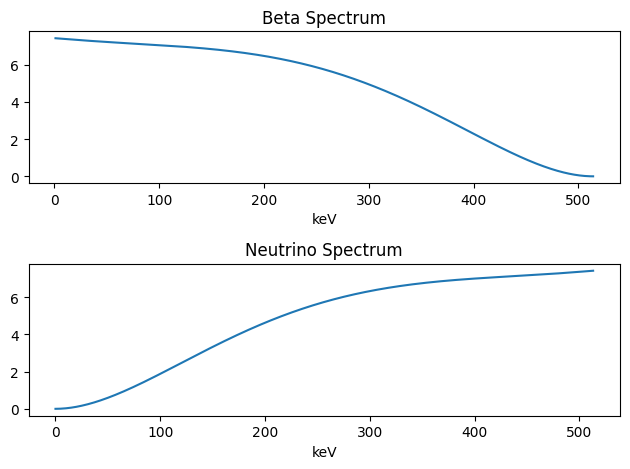

In [97]:
# Initial Spectra Generation
Q = 514.03
Cs137 = Isotope("Cs137", 55, 137, 7/2, +1)
Ba137 = Isotope("Ba137", 56, 137, 11/2, -1)

beta = SetDecayProcess(Cs137, Ba137, Q)
K = np.linspace(0, Q, 514)

s = [beta_spectrum(beta, z) for z in K]
q = [neutrino_spectrum(beta, z) for z in K]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(K, s)
ax1.set_title('Beta Spectrum')
ax1.set_xlabel('keV')

ax2.plot(K, q)
ax2.set_title('Neutrino Spectrum')
ax2.set_xlabel('keV')

plt.tight_layout()
plt.show()

In [98]:
# Normalizing
s = s[1:-1]
norm_num_beta = preprocessing.normalize([s])

sum_beta = 0
for i in norm_num_beta[0] :
    sum_beta = sum_beta + (i*Q/len(K-2))
    
numbers_beta_final = []
for i in norm_num_beta[0] : 
    numbers_beta_final.append(i/sum_beta*0.947)

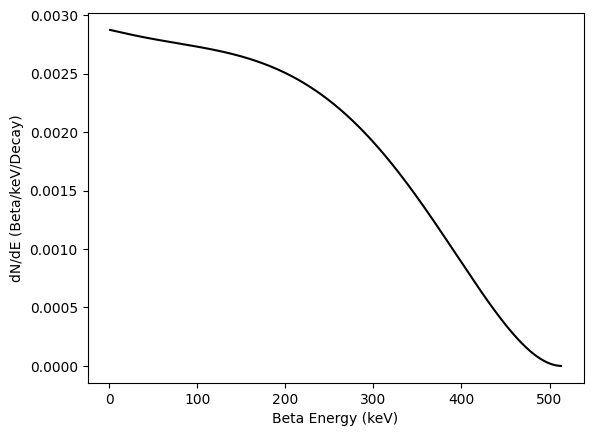

In [99]:
# Plot
K = K[1:-1]
plt.plot(K, numbers_beta_final, color='black')
plt.xlabel('Beta Energy (keV)')
plt.ylabel('dN/dE (Beta/keV/Decay)')
plt.savefig('Cs-137_Path1_Beta.png')

In [119]:
# Normalizing
q = q[1:-1]
norm_num_nu = preprocessing.normalize([q])

sum_nu = 0
for i in norm_num_nu[0] :
    sum_nu = sum_nu + (i*514/len(K))
    
numbers_nu_final = []
for i in norm_num_nu[0] : 
    numbers_nu_final.append(i/sum_nu*0.947)

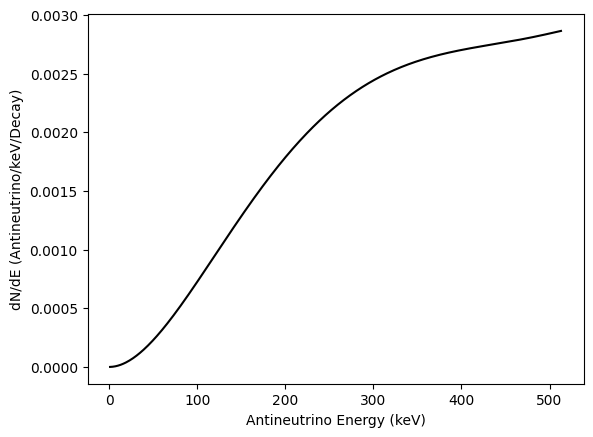

In [101]:
# Plot
plt.plot(K, numbers_nu_final, color='black')
plt.xlabel('Antineutrino Energy (keV)')
plt.ylabel('dN/dE (Antineutrino/keV/Decay)')
plt.savefig('Cs-137_Path1_nu.png')

In [102]:
# Save Variables
s_1 = numbers_beta_final
q_1 = numbers_nu_final
K_1 = K

In [103]:
### Create Decay Path 2 Spectra

/var/folders/n3/xh3ln6d90nq66qj5yx9pyg8h0000gn/T/ipykernel_20559/3411488386.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  y = α * Z * W / p(W)
/var/folders/n3/xh3ln6d90nq66qj5yx9pyg8h0000gn/T/ipykernel_20559/3411488386.py:68: RuntimeWarning: invalid value encountered in double_scalars
  Ω = np.sqrt(np.abs(1 - l * W)) * (omega)**γ * np.exp(np.pi * y / 2) * np.abs(gamma(𝛋)) / gamma(β)


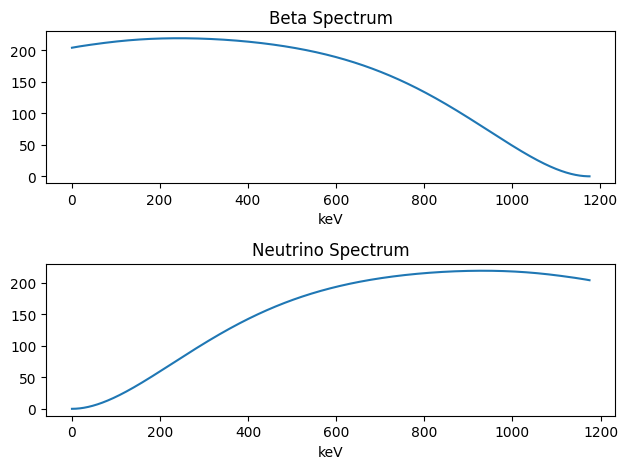

In [104]:
# Initial Spectra Generation
Q = 1176
Cs137 = Isotope("Cs137", 55, 137, 7/2, +1)
Ba137 = Isotope("Ba137", 56, 137, 11/2, -1)

beta = SetDecayProcess(Cs137, Ba137, Q)
K = np.linspace(0, Q, 1176)

s = [beta_spectrum(beta, z) for z in K]
q = [neutrino_spectrum(beta, z) for z in K]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(K, s)
ax1.set_title('Beta Spectrum')
ax1.set_xlabel('keV')

ax2.plot(K, q)
ax2.set_title('Neutrino Spectrum')
ax2.set_xlabel('keV')

plt.tight_layout()
plt.show()

In [105]:
# Normalizing
s = s[1:-1]
norm_num_beta = preprocessing.normalize([s])

sum_beta = 0
for i in norm_num_beta[0] :
    sum_beta = sum_beta + (i*Q/len(K-2))
    
numbers_beta_final = []
for i in norm_num_beta[0] : 
    numbers_beta_final.append(i/sum_beta*0.053)

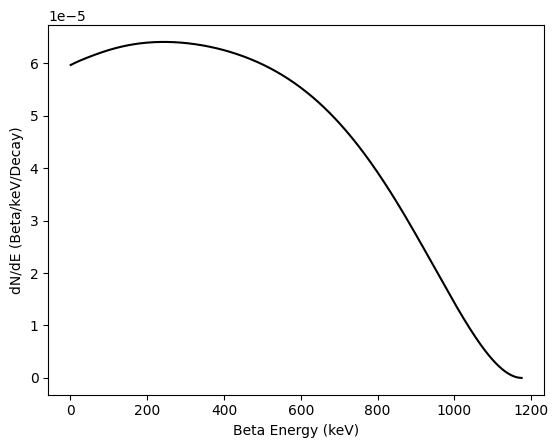

In [106]:
# Plot
K = K[1:-1]
plt.plot(K, numbers_beta_final, color='black')
plt.xlabel('Beta Energy (keV)')
plt.ylabel('dN/dE (Beta/keV/Decay)')
plt.savefig('Cs-137_Path2_beta.png')

In [107]:
# Normalizing
q = q[1:-1]
norm_num_nu = preprocessing.normalize([q])

sum_nu = 0
for i in norm_num_nu[0] :
    sum_nu = sum_nu + (i*Q/len(K))
    
numbers_nu_final = []
for i in norm_num_nu[0] : 
    numbers_nu_final.append(i/sum_nu*0.053)

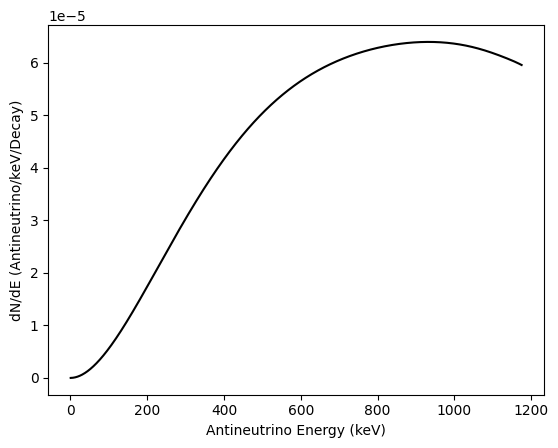

In [108]:
# Plot
plt.plot(K, numbers_nu_final, color='black')
plt.xlabel('Antineutrino Energy (keV)')
plt.ylabel('dN/dE (Antineutrino/keV/Decay)')
plt.savefig('Cs-137_Path2_nu.png')

In [109]:
# Save Variables
s_2 = numbers_beta_final
q_2 = numbers_nu_final
K_2 = K

In [110]:
### Combining Spectra

In [111]:
total_K = []
total_beta = []
total_nu = []
for i in range(len(K_1)):
        total_K.append(K_1[i])
        beta = s_1[i] + s_2[i]
        total_beta.append(beta)
        nu = q_1[i] + q_2[i]
        total_nu.append(nu)

for i in range(len(K_2)):
    if i >= 512 :
        total_K.append(K_2[i])
        total_beta.append(s_2[i])
        total_nu.append(q_2[i])

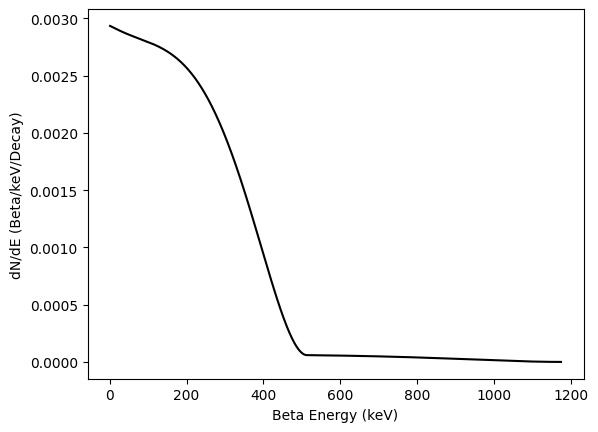

In [112]:
# Plot Beta Spectrum
plt.plot(K_2, total_beta, color='black')
plt.xlabel('Beta Energy (keV)')
plt.ylabel('dN/dE (Beta/keV/Decay)')
plt.savefig('Cs-137_beta.png')

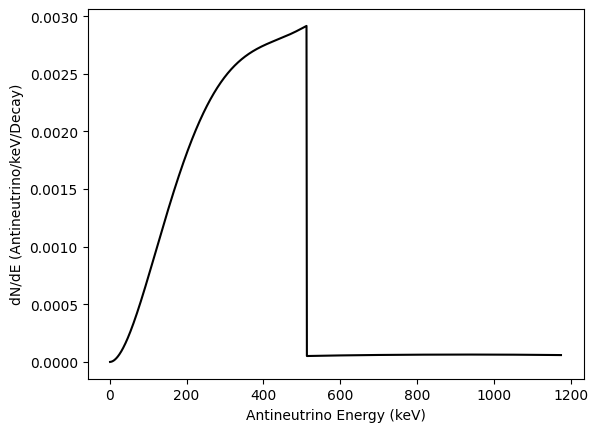

In [113]:
# Plot Antineutrino Spectrum
plt.plot(K_2, total_nu, color='black')
plt.xlabel('Antineutrino Energy (keV)')
plt.ylabel('dN/dE (Antineutrino/keV/Decay)')
plt.savefig('Cs-137_nu.png')

In [114]:
### Download Data

In [115]:
csv_file = 'cs-137_spectrum.csv'
with open(csv_file, 'w', newline='') as file:
    fieldnames = ['energy', 'dN/dE']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(K_2)) :
        writer.writerow({'energy': K_2[i], 'dN/dE': total_nu[i]})

In [116]:
csv_file = 'cs-137_spectrum_beta.csv'
with open(csv_file, 'w', newline='') as file:
    fieldnames = ['energy', 'dN/dE']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(K_2)) :
        writer.writerow({'energy': K_2[i], 'dN/dE': total_beta[i]})